In [1]:
# === BLOCCO 1 - IMPORT LIBRERIE ===
import os
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import time
import seaborn as sns

# ML utils
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Classificatori
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Perceptron

# Deep learning
import tensorflow as tf
from tensorflow import keras

In [2]:
# ===============================================
# === BLOCCO 2 - LETTURA IMMAGINI E LABEL ===
# ===============================================

base_dir = Path('/Users/matteobraglia/Desktop/PROGETTO DATA/IndustryBiscuit/Images')
labels_csv = pd.read_csv('/Users/matteobraglia/Desktop/PROGETTO DATA/IndustryBiscuit/Annotations.csv')

file_to_class = dict(zip(labels_csv['file'], labels_csv['classCode']))

images, labels = [], []

for img_file in base_dir.glob("*.jpg"):
    try:
        img = Image.open(img_file).convert("RGB")
        images.append(np.array(img))
        labels.append(file_to_class[img_file.name])
    except Exception as e:
        print("Errore su", img_file, ":", e)

X = np.stack(images)
y = np.array(labels, dtype=np.int64)

class_mapping = dict(zip(labels_csv['classCode'], labels_csv['classDescription']))
num_classes = len(class_mapping)

print("Shape immagini:", X.shape)
print("Shape labels:", y.shape)
print("Classi:", class_mapping)

Shape immagini: (4900, 256, 256, 3)
Shape labels: (4900,)
Classi: {1: 'Defect_Shape', 2: 'Defect_Object', 3: 'Defect_Color', 0: 'Defect_No'}


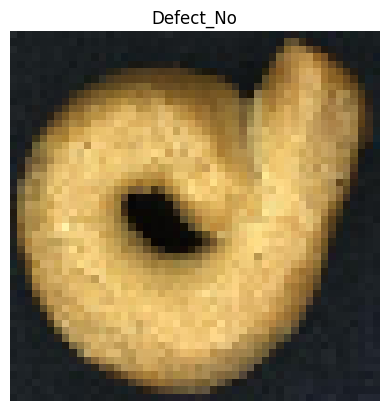

In [3]:
# ===============================================
# === BLOCCO 4 - RIDIMENSIONAMENTO A 50x50 ===
# ===============================================

def resize_to_50(img):
    h, w = img.shape[:2]
    y_idx = np.linspace(0, h-1, 50).round().astype(int)
    x_idx = np.linspace(0, w-1, 50).round().astype(int)
    return img[y_idx][:, x_idx]

X50 = np.stack([resize_to_50(im) for im in X])
X50 = X50.astype("float32") / 255

# Visualizza un esempio ridimensionato
id = 175
plt.imshow(X50[id])
plt.title(class_mapping[y[id]])
plt.axis('off')
plt.show()

In [4]:
# ===============================================
# === BLOCCO 5 - TRAIN/TEST SPLIT ===
# ===============================================

x_train, x_test, y_train, y_test = train_test_split(
    X50, y, test_size=0.2, random_state=42, stratify=y
)

print('Train shape:', x_train.shape, 'Test shape:', x_test.shape)

Train shape: (3920, 50, 50, 3) Test shape: (980, 50, 50, 3)


In [5]:
# ===============================================
# === BLOCCO 6 - PCA + ML CLASSICI (RGB) ===
# ===============================================

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def fit_pca_features_rgb(X_train, n_components=100):
    N = X_train.shape[0]
    # Flattening mantenendo i 3 canali (R,G,B)
    X_flat = X_train.reshape(N, -1)
    # Standardizzazione
    scaler = StandardScaler().fit(X_flat)
    X_s = scaler.transform(X_flat)
    # PCA con n_components fissato a 100
    pca = PCA(n_components=n_components, random_state=42).fit(X_s)
    X_pca = pca.transform(X_s)
    return X_pca, scaler, pca

def transform_pca_features_rgb(X, scaler, pca):
    N = X.shape[0]
    X_flat = X.reshape(N, -1)
    X_s = scaler.transform(X_flat)
    return pca.transform(X_s)

# Esempio di utilizzo
X_train_feat, scaler, pca = fit_pca_features_rgb(x_train, n_components=100)
X_test_feat = transform_pca_features_rgb(x_test, scaler, pca)

print("Train features:", X_train_feat.shape)
print("Test features:", X_test_feat.shape)

# Helper valutazione
results = []

def evaluate_and_save(name, model, X_test_feat, y_test, y_pred, best_params=None, fit_time=None):
    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    macro_prec = precision_score(y_test, y_pred, average='macro')
    macro_rec = recall_score(y_test, y_pred, average='macro')

    print(f"\n===== {name} =====")
    print("Accuracy:", acc)
    print("F1-macro:", macro_f1)
    print("Precision-macro:", macro_prec)
    print("Recall-macro:", macro_rec)
    print("Best params:", best_params)

    results.append({
        "model": name,
        "accuracy": acc,
        "macro_f1": macro_f1,
        "macro_precision": macro_prec,
        "macro_recall": macro_rec,
        "best_params": best_params,
        "fit_time_sec": fit_time
    })

def plot_cm(model_name, y_true, y_pred, class_mapping):
    labels = [class_mapping[i] for i in range(len(class_mapping))]
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


Train features: (3920, 100)
Test features: (980, 100)



===== KNN =====
Accuracy: 0.7806122448979592
F1-macro: 0.6949634839787641
Precision-macro: 0.8240991930361197
Recall-macro: 0.6631613587998244
Best params: {'metric': 'euclidean', 'n_neighbors': 3}


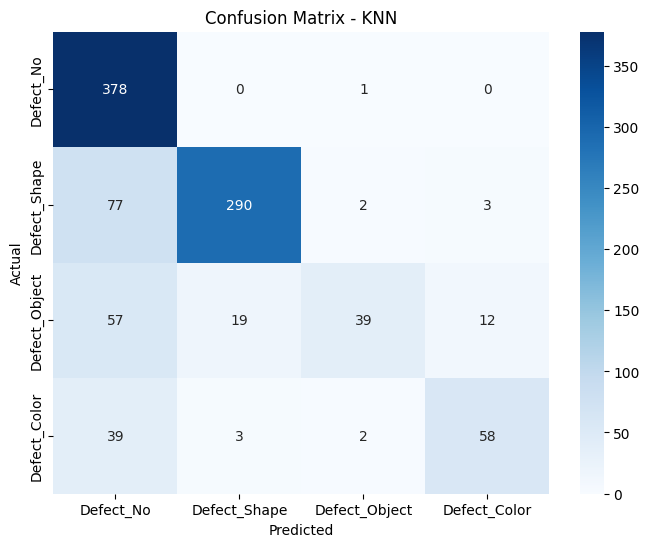

In [6]:
# ===== GridSearch + Modelli Classici =====
# KNN
param_grid = {"n_neighbors": [3,5,7], "metric": ["euclidean", "manhattan"]}
gs = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
t0 = time.time()
gs.fit(X_train_feat, y_train)
t1 = time.time()
y_pred = gs.best_estimator_.predict(X_test_feat)
evaluate_and_save("KNN", gs.best_estimator_, X_test_feat, y_test, y_pred, gs.best_params_, t1-t0)

plot_cm("KNN", y_test, y_pred, class_mapping)


===== DecisionTree =====
Accuracy: 0.786734693877551
F1-macro: 0.7491343166032493
Precision-macro: 0.7592230325479922
Recall-macro: 0.7425955152753597
Best params: {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 10}


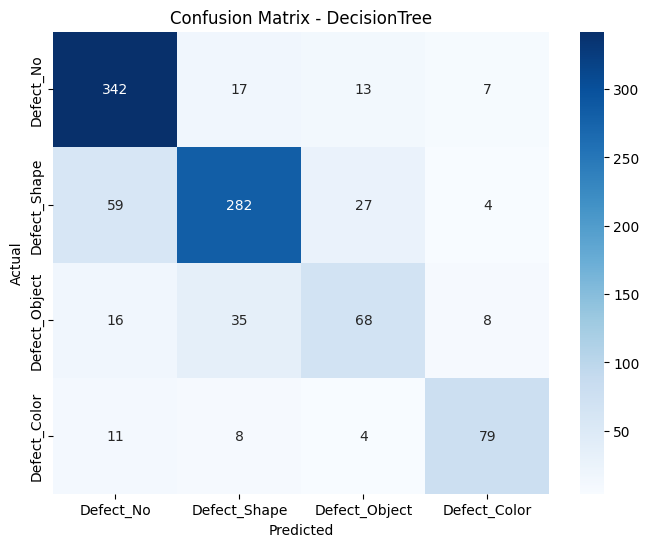

In [7]:
# DecisionTree
param_grid = {"criterion": ["gini","entropy"], "max_depth": [None,5,10,20], "ccp_alpha": [0.0,0.001,0.005]}
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
t0 = time.time()
gs.fit(X_train_feat, y_train)
t1 = time.time()
y_pred = gs.best_estimator_.predict(X_test_feat)
evaluate_and_save("DecisionTree", gs.best_estimator_, X_test_feat, y_test, y_pred, gs.best_params_, t1-t0)

plot_cm("DecisionTree", y_test, y_pred, class_mapping)


===== LogisticRegression =====
Accuracy: 0.7479591836734694
F1-macro: 0.6873866510062374
Precision-macro: 0.7132958919550081
Recall-macro: 0.6716147470915668
Best params: {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


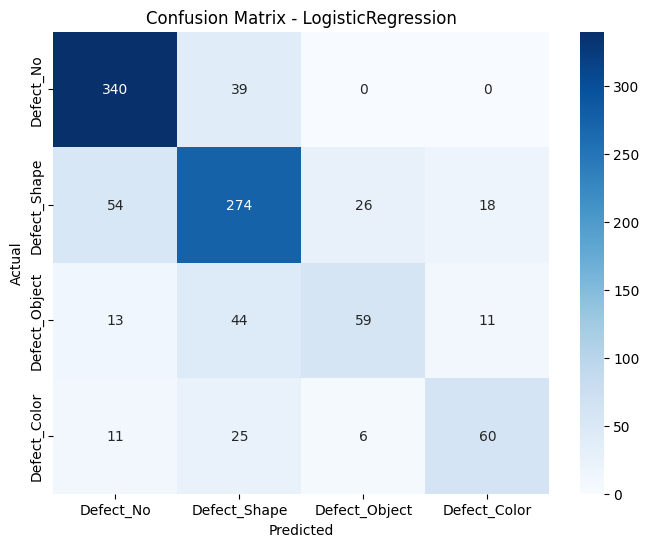

In [8]:
# LogisticRegression
param_grid = {"C":[0.1,1,10], "solver":["lbfgs"], "penalty":["l2"], "max_iter":[1000]}
gs = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
t0 = time.time()
gs.fit(X_train_feat, y_train)
t1 = time.time()
y_pred = gs.best_estimator_.predict(X_test_feat)
evaluate_and_save("LogisticRegression", gs.best_estimator_, X_test_feat, y_test, y_pred, gs.best_params_, t1-t0)

plot_cm("LogisticRegression", y_test, y_pred, class_mapping)


===== Perceptron =====
Accuracy: 0.6020408163265306
F1-macro: 0.5480642713265166
Precision-macro: 0.5471062043355165
Recall-macro: 0.5496353420858842
Best params: {'alpha': 0.0001, 'max_iter': 1000, 'penalty': None}


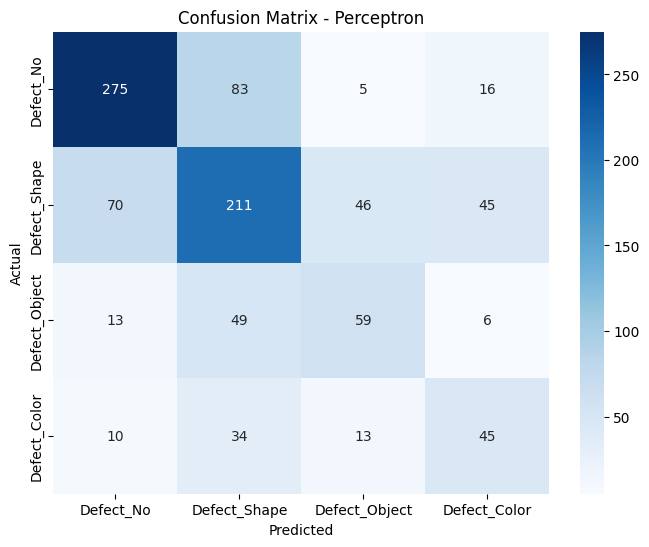

In [9]:
# Perceptron
param_grid = {"alpha":[1e-4,1e-3,1e-2], "penalty":[None,"l2"], "max_iter":[1000]}
gs = GridSearchCV(Perceptron(random_state=42), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
t0 = time.time()
gs.fit(X_train_feat, y_train)
t1 = time.time()
y_pred = gs.best_estimator_.predict(X_test_feat)
evaluate_and_save("Perceptron", gs.best_estimator_, X_test_feat, y_test, y_pred, gs.best_params_, t1-t0)

plot_cm("Perceptron", y_test, y_pred, class_mapping)

In [10]:
# Risultati finali modelli classici
df_results = pd.DataFrame(results).sort_values("accuracy", ascending=False)
print("\n===== RISULTATI CLASSICI =====")
print(df_results.to_string(index=False))


===== RISULTATI CLASSICI =====
             model  accuracy  macro_f1  macro_precision  macro_recall                                                    best_params  fit_time_sec
      DecisionTree  0.786735  0.749134         0.759223      0.742596    {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 10}     37.209576
               KNN  0.780612  0.694963         0.824099      0.663161                      {'metric': 'euclidean', 'n_neighbors': 3}      5.432260
LogisticRegression  0.747959  0.687387         0.713296      0.671615 {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}      1.948042
        Perceptron  0.602041  0.548064         0.547106      0.549635           {'alpha': 0.0001, 'max_iter': 1000, 'penalty': None}      0.514229


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 260,676 (1018.27 KB)

 Trainable params: 260,676 (1018.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 104s 971ms/step - accuracy: 0.4735 - loss: 1.0983 - val_accuracy: 0.5740 - val_loss: 0.9014
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 93s 953ms/step - accuracy: 0.6059 - loss: 0.9360 - val_accuracy: 0.7768 - val_loss: 0.7627
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 89s 911ms/step - accuracy: 0.7602 - loss: 0.6925 - val_accuracy: 0.8240 - val_loss: 0.5767
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 85s 868ms/step - accuracy: 0.8173 - loss: 0.5610 - val_accuracy: 0.8737 - val_loss: 0.4753
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 89s 910ms/step - accuracy: 0.8457 - loss: 0.4889 - val_accuracy: 0.9018 - val_loss: 0.3454
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 85s 865ms/step - accuracy: 0.8686 - loss: 0.4328 - val_accuracy: 0.8980 - val_loss: 0.3439
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 83s 844ms/step - accuracy: 0.8903 - loss: 0.3670 - val_accuracy: 0.8622 - val_loss: 0.3660
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 83s 849ms/step - accuracy: 0.9011 - loss: 0.3307 - val_acc

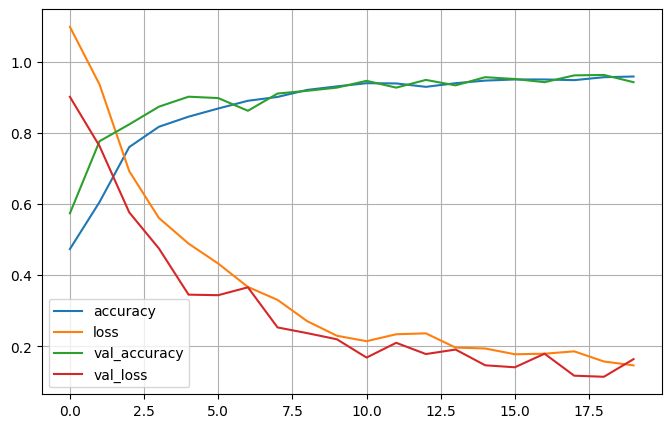

31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 264ms/step


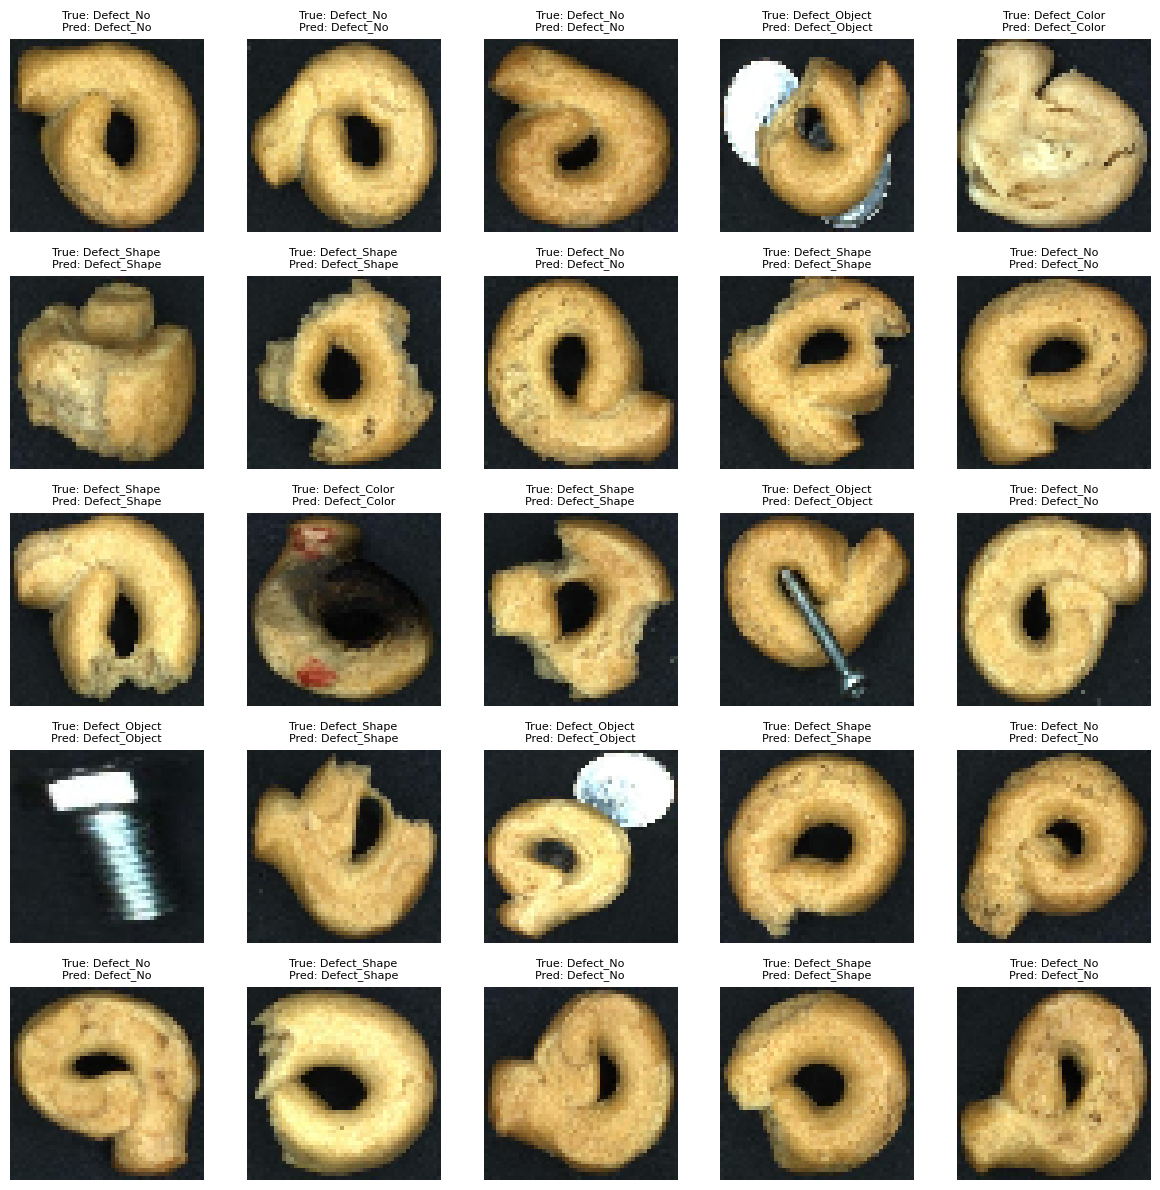

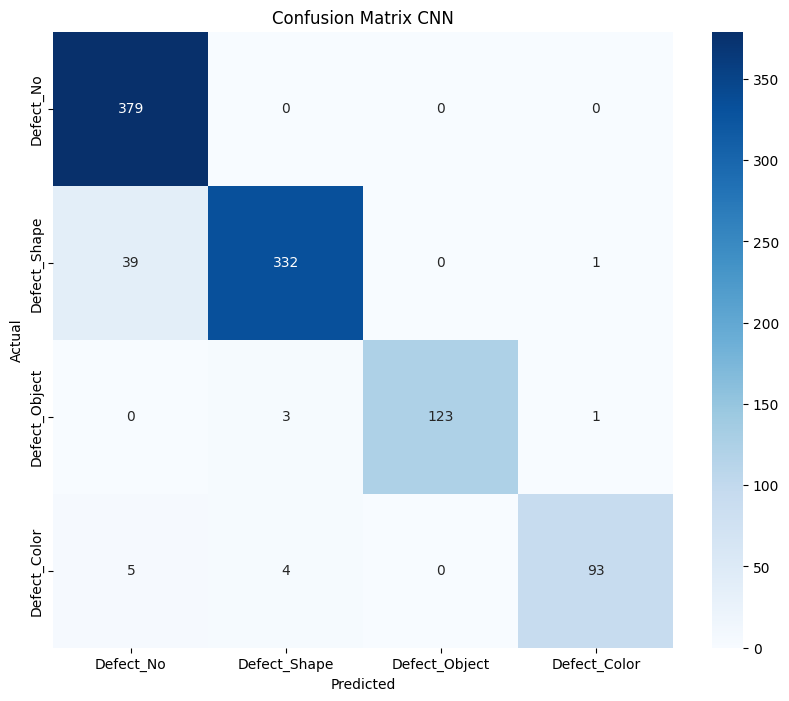

In [11]:
# ===============================================
# === BLOCCO 7 - CNN ===
# ===============================================

input_shape = (50,50,3)
model = keras.Sequential([
    keras.layers.Input(shape=input_shape),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(128,(3,3),activation='relu'),
    keras.layers.Conv2D(128,(3,3),activation='relu'),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]

history = model.fit(x_train, y_train, epochs=20, validation_split=0.2, callbacks=callbacks)

# Storia training
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

# Predict
predictions = model.predict(x_test)
cpredictions = [np.argmax(p) for p in predictions]

# Griglia immagini predizioni
plt.figure(figsize=(12,12))
for i in range(1,26):
    img = x_test[-i]
    plt.subplot(5,5,i)
    plt.imshow(img)
    plt.title(f"True: {class_mapping[y_test[-i]]}\nPred: {class_mapping[cpredictions[-i]]}", fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Confusion matrix CNN
label_names = [class_mapping[i] for i in range(num_classes)]
cm = confusion_matrix(y_test, cpredictions)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix CNN')
plt.show()